## Pet Finder Competition

https://www.kaggle.com/competitions/petfinder-adoption-prediction

In [12]:
## LIBRERIAS ##
#libraries
import numpy as np 
import pandas as pd 
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#import lightgbm as lgb
#import xgboost as xgb
import time
import datetime
from PIL import Image

import gc
#from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial


In [13]:
df_breeds = pd.read_csv('../input/breed_labels.csv')
colors = pd.read_csv('../input/color_labels.csv')
states = pd.read_csv('../input/state_labels.csv')

train = pd.read_csv('../input/train/train.csv')
test = pd.read_csv('../input/test/test.csv')
sub = pd.read_csv('../input/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

train.drop('Description', axis=1).head()


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


In [14]:
df_breeds.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [15]:
train.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [16]:
# Tamaño del dataset
print(train.shape)     # 14993 registros, 24 variables

# Name of columns
print(train.columns)

#Revisar tipo y nulos
train.info()
train.isnull().sum()

(14993, 25)
Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'dataset_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurL

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dataset_type        0
dtype: int64

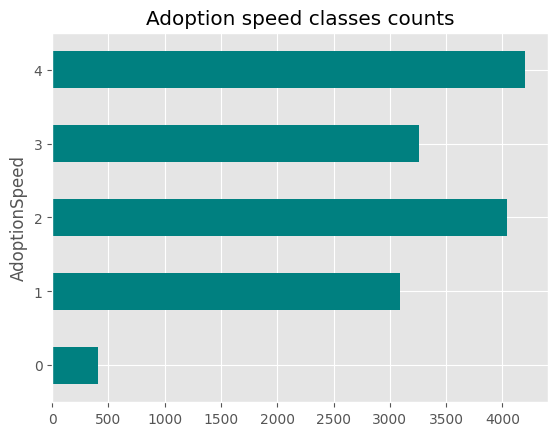

In [17]:
train['AdoptionSpeed'].value_counts().sort_index().plot(kind='barh', color='teal')
plt.title('Adoption speed classes counts')
plt.show()

#0 - La mascota fue adoptada el mismo día en que fue registrada.
#1 - La mascota fue adoptada entre 1 y 7 días (1ra semana) después de ser registrada.
#2 - La mascota fue adoptada entre 8 y 30 días (1er mes) después de ser registrada.
#3 - La mascota fue adoptada entre 31 y 90 días (2do y 3er mes) después de ser registrada.
#4 - No hubo adopción después de 100 días de ser registrada. (No hay mascotas en este conjunto de datos que hayan esperado entre 90 y 100 días).

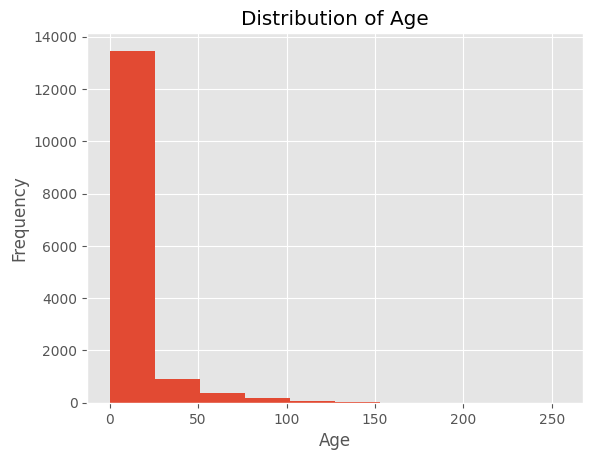

In [18]:
# Univariate Analysis
# Histogram for Age
plt.hist(train['Age'])
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

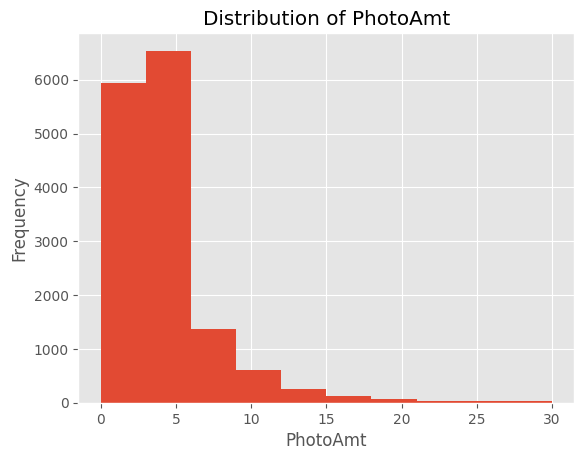

In [19]:
# Univariate Analysis
# Histogram for PhotoAmt
plt.hist(train['PhotoAmt'])
plt.title('Distribution of PhotoAmt')
plt.xlabel('PhotoAmt')
plt.ylabel('Frequency')
plt.show()

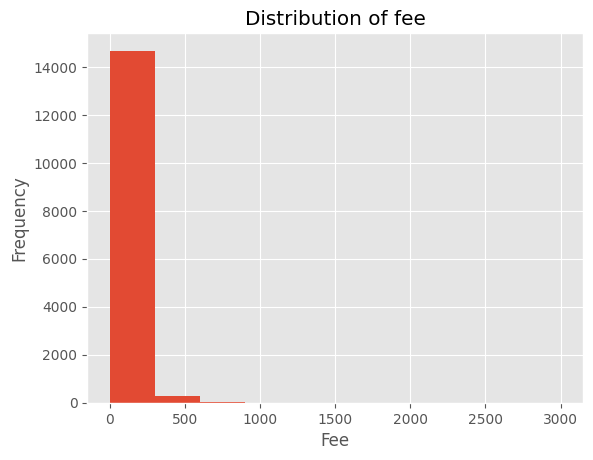

In [20]:
# Univariate Analysis
# Histogram for PhotoAmt
plt.hist(train['Fee'])
plt.title('Distribution of fee')
plt.xlabel('Fee')
plt.ylabel('Frequency')
plt.show()

In [24]:
df=train

In [25]:
# Missing values per variable

# Cambio variables no especificadas (ejemplo: 0) a NA
df['MaturitySize'] = df['MaturitySize'].replace(0, pd.NA)
df['FurLength'] = df['FurLength'].replace(0, pd.NA)
df['Vaccinated'] = df['Vaccinated'].replace(3, pd.NA)
df['Dewormed'] = df['Dewormed'].replace(3, pd.NA)
df['Sterilized'] = df['Sterilized'].replace(3, pd.NA)
df['Health'] = df['Health'].replace(0, pd.NA)

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Campos faltantes por variable:")
print(missing_values)

Campos faltantes por variable:
Name           1265
Vaccinated     1868
Dewormed       1781
Sterilized     1815
Description      13
dtype: int64


In [26]:
# Dataset summary
print(df.describe())

               Type           Age        Breed1        Breed2        Gender  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.457614     10.452078    265.272594     74.009738      1.776162   
std        0.498217     18.155790     60.056818    123.011575      0.681592   
min        1.000000      0.000000      0.000000      0.000000      1.000000   
25%        1.000000      2.000000    265.000000      0.000000      1.000000   
50%        1.000000      3.000000    266.000000      0.000000      2.000000   
75%        2.000000     12.000000    307.000000    179.000000      2.000000   
max        2.000000    255.000000    307.000000    307.000000      3.000000   

             Color1        Color2        Color3  MaturitySize     FurLength  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       2.234176      3.222837      1.882012      1.862002      1.467485   
std        1.745225      2.742562      2.984086    

### Variables Base
- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

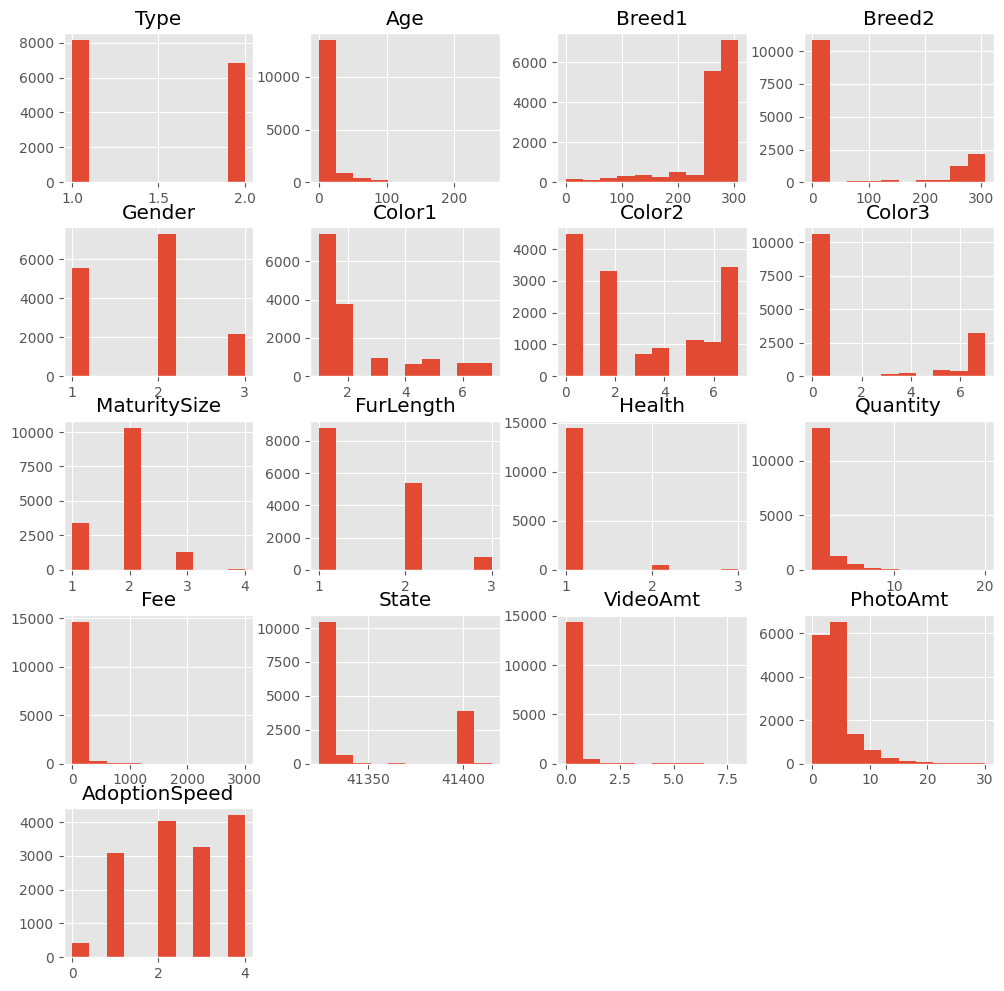

In [27]:
# Variables histograms

import matplotlib.pyplot as plt

df.hist(figsize=(12, 12))
plt.show()

In [28]:
# Pets of mixed breed (Breed1 = 307)
count = df[df['Breed1'] == 307].shape[0]
print(count)    # 1499

# Las 10 razas mas comunes (Breed1)
breed_counts = df['Breed1'].value_counts()
most_common_breeds = breed_counts.nlargest(10)
print(most_common_breeds)
#most_common_breeds_names = df_breeds[df_breeds['BreedID'].isin(most_common_breeds.index)]['BreedName']
#for breed, count in zip(most_common_breeds_names, most_common_breeds):
#    print(f"{breed}: {count}")

# Las 10 razas mas comunes (Breed2)
breed2_counts = df['Breed2'].value_counts()
most_common_breeds2 = breed2_counts.nlargest(10)
print(most_common_breeds2)



5927
Breed1
307    5927
266    3634
265    1258
299     342
264     296
292     264
285     221
141     205
205     190
179     167
Name: count, dtype: int64
Breed2
0      10762
307     1727
266      599
265      321
299      138
264      125
292      105
218       91
141       86
285       78
Name: count, dtype: int64


In [31]:
# Correlation of variables

df_numerical = df.select_dtypes(include=['int64', 'float64'])

df_numerical.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

#sns.pairplot(df, hue="AdoptionSpeed")
#plt.show()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
Type,1.0,-0.15,0.058,-0.044,0.061,0.098,0.25,0.2,-0.17,0.003,-0.0069,0.036,-0.042,0.12,-0.006,0.049,-0.091
Age,-0.15,1.0,-0.31,-0.041,-0.12,0.09,-0.039,-0.054,0.094,0.15,0.1,-0.11,0.089,0.025,-0.016,-0.085,0.1
Breed1,0.058,-0.31,1.0,-0.16,0.071,-0.036,-0.0071,-0.00068,-0.011,-0.11,-0.035,0.09,-0.19,-0.027,0.021,0.043,0.11
Breed2,-0.044,-0.041,-0.16,1.0,0.057,-0.02,0.003,0.036,0.05,0.11,-0.029,0.038,0.014,-0.038,0.0016,0.046,-0.019
Gender,0.061,-0.12,0.071,0.057,1.0,-0.12,0.027,0.26,-0.092,-0.03,-0.045,0.49,-0.05,0.0026,0.017,0.098,0.058
Color1,0.098,0.09,-0.036,-0.02,-0.12,1.0,-0.11,-0.28,-0.029,0.067,0.024,-0.12,0.054,0.024,-0.0064,-0.041,-0.044
Color2,0.25,-0.039,-0.0071,0.003,0.027,-0.11,1.0,0.089,-0.065,-0.0088,-0.0043,0.02,-0.017,0.027,0.024,0.059,-0.039
Color3,0.2,-0.054,-0.00068,0.036,0.26,-0.28,0.089,1.0,-0.052,0.014,-0.025,0.27,-0.02,0.011,0.02,0.1,-0.007
MaturitySize,-0.17,0.094,-0.011,0.05,-0.092,-0.029,-0.065,-0.052,1.0,0.095,-0.013,-0.043,0.041,-0.063,0.017,0.016,0.046
FurLength,0.003,0.15,-0.11,0.11,-0.03,0.067,-0.0088,0.014,0.095,1.0,0.028,-0.038,0.16,-0.029,-0.015,-0.032,-0.091


## Analisis exploratorio clase 7

Text(0.5, 1.0, 'Adoption speed classes counts')

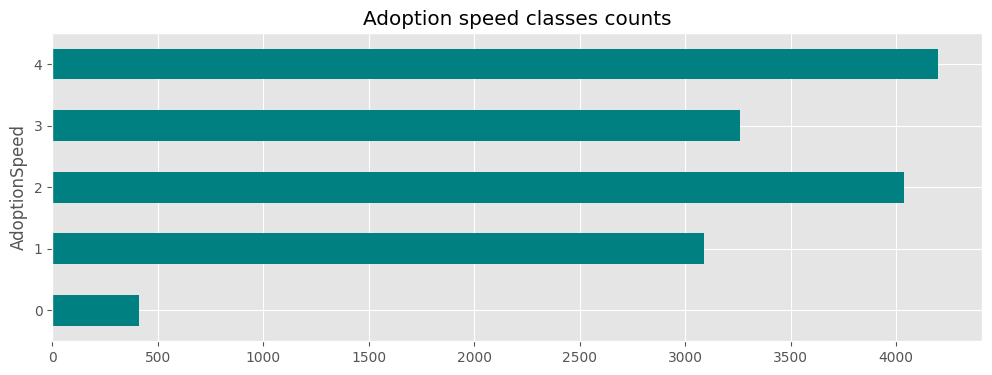

In [34]:
plt.figure(figsize=(12, 4))
df['AdoptionSpeed'].value_counts().sort_index().plot(kind='barh', color='teal')
plt.title('Adoption speed classes counts')

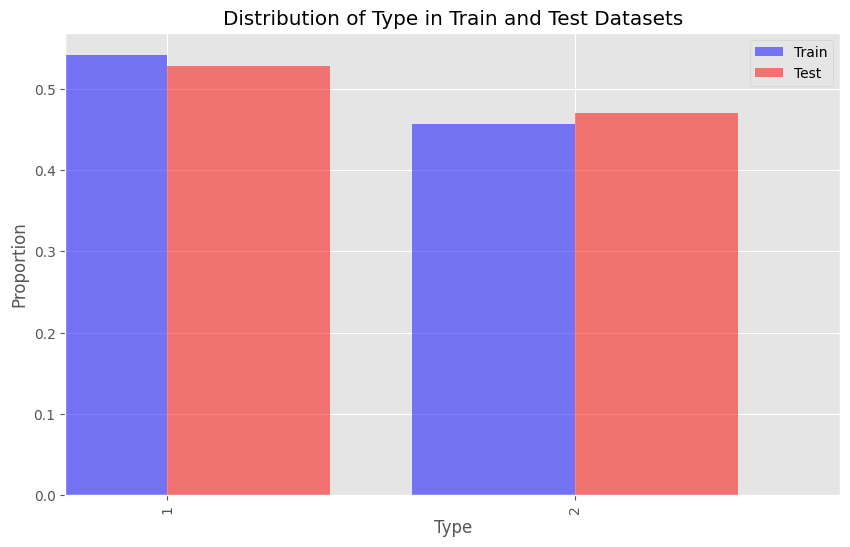

In [35]:
# Plot the difference in the distribution of 'Type' between test and train datasets
plt.figure(figsize=(10, 6))

# Plot for train dataset
train['Type'].value_counts(normalize=True).plot(kind='bar', alpha=0.5, color='blue', position=1, width=0.4, label='Train')

# Plot for test dataset
test['Type'].value_counts(normalize=True).plot(kind='bar', alpha=0.5, color='red', position=0, width=0.4, label='Test')

plt.title('Distribution of Type in Train and Test Datasets')
plt.xlabel('Type')
plt.ylabel('Proportion')
plt.legend()
plt.show()

AdoptionSpeed  0.0   1.0   2.0   3.0   4.0
HasName                                   
False           26   273   313   218   435
True           384  2817  3724  3041  3762


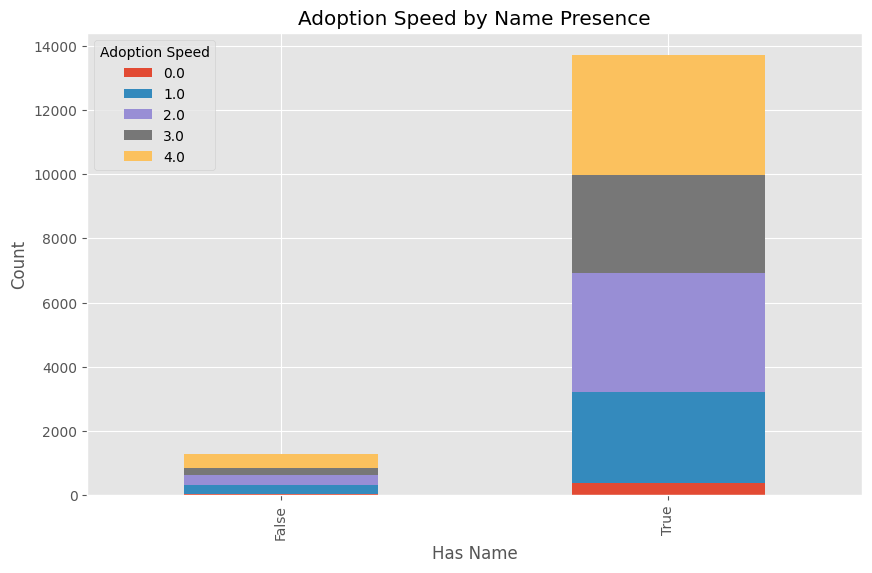

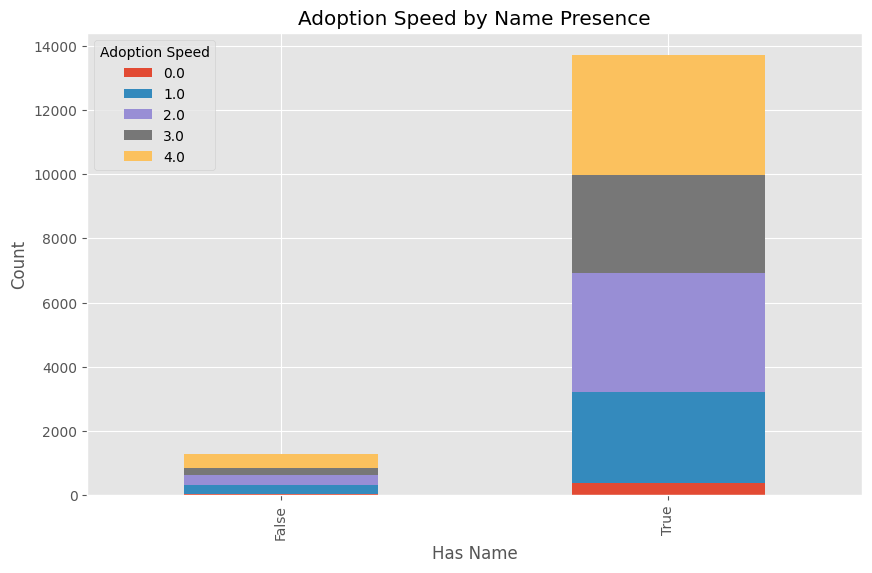

In [37]:
# Create a new column to indicate if the pet has a name
all_data['HasName'] = all_data['Name'].notnull()

# Group by 'HasName' and 'AdoptionSpeed' and count the occurrences
adoption_speed_name = all_data.groupby(['HasName', 'AdoptionSpeed']).size().unstack()

# Display the table
print(adoption_speed_name)

# Display the frequency
adoption_speed_name.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adoption Speed by Name Presence')
plt.xlabel('Has Name')
plt.ylabel('Count')
plt.legend(title='Adoption Speed')
plt.show()
adoption_speed_name = all_data.groupby(['HasName', 'AdoptionSpeed']).size().unstack()

# Plot the data
adoption_speed_name.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adoption Speed by Name Presence')
plt.xlabel('Has Name')
plt.ylabel('Count')
plt.legend(title='Adoption Speed')
plt.show()